In [1]:
# ! pip install lime
# ! pip install shap
# ! pip install sklearn
# ! pip install xgboost
# ! pip instsall matplotlib seaborn pandas numpy

# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20XGBoost.html#Explain-predictions

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import lime
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score

In [2]:
import xgboost as xgb

C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
import shap

In [4]:
shap.initjs()

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
def separate_dataset(X, y):
    length = len(X)
    train_length = int(0.8 * length)
    X_train, y_train = X.iloc[:train_length, :], y[:train_length]
    X_test, y_test = X.iloc[train_length:], y[train_length:]
    return X_train, y_train, X_test, y_test

In [7]:
# def convert_category(df):
#     df1 = df.copy()
#     for col_name in df.columns:
#         if(df1[col_name].dtype == 'object'):
#             df1[col_name] = df1[col_name].astype('category')
#             df1[col_name] = df1[col_name].cat.codes
#     return df1

def column_to_onehot(df, field, cats):
    for x in cats:
        df['%s_%s' % (field, x)] = np.zeros(len(df), dtype=np.int32)

    data = df[field].to_numpy()
    for i, x in enumerate(data):
        df.iloc[i, df.columns.get_loc('%s_%s' % (field, x))] = 1
    df.drop(field, inplace=True, axis=1)

def to_onehot(df, excepts):
    df1 = df.copy()
    for col_name in df.columns:
        if not col_name in excepts and df1[col_name].dtype == 'object':
            column_to_onehot(df1, col_name, cats[col_name])
    return df1

**1. Load data**

**1.1 Ecommerce**

An international e-commerce company based wants to discover key insights from their customer database. They want to use some of the most advanced machine learning techniques to study their customers. The company sells electronic products.

Content
The dataset used for model building contained **10999** observations of 12 variables.
The data contains the following information:

- ID: ID Number of Customers.
- Warehouse block: The Company have big Warehouse which is divided in to block such as A,B,C,D,E.
- Mode of shipment:The Company Ships the products in multiple way such as Ship, Flight and Road.
- Customer care calls: The number of calls made from enquiry for enquiry of the shipment.
- Customer rating: The company has rated from every customer. 1 is the lowest (Worst), 5 is the highest (Best).
- Cost of the product: Cost of the Product in US Dollars.
- Prior purchases: The Number of Prior Purchase.
- Product importance: The company has categorized the product in the various parameter such as low, medium, high.
- Gender: Male and Female.
- Discount offered: Discount offered on that specific product.
- Weight in gms: It is the weight in grams.
- Reached on time: It is the target variable, where 1 Indicates that the product has NOT reached on time and 0 indicates it has reached on time.

Acknowledgements
I would like to specify that I am only making available on Github in Data collected data about product shipment to Kagglers. I made this as my project on Customer Analytics stored in GitHub repository.

Inspiration
This data of Product Shipment Tracking, answer instantly to your questions:

What was Customer Rating? And was the product delivered on time?
Is Customer query is being answered?
If Product importance is high. having higest rating or being delivered on time?

In [9]:
ecommerce = pd.read_csv("./data/ecommerce/ecommerce.csv")

In [10]:
ecommerce['Product_importance'].replace(to_replace=['low', 'medium', 'high'], value=[1,2,3], inplace=True)

In [11]:
ecommerce['Gender'].replace(to_replace=['M', 'F'], value=[1,0], inplace=True)

In [12]:
column_to_onehot(ecommerce, 'Mode_of_Shipment', ['Flight', 'Ship', 'Road'])

In [13]:
column_to_onehot(ecommerce, 'Warehouse_block', ['A', 'B', 'C', 'D', 'F'])

**Problem 1: Rating prediction**

In [14]:
rating_data = ecommerce.copy()

In [15]:
rt_corr = rating_data.corr()
rt_corr.iloc[2:3,:]

,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N,Mode_of_Shipment_Flight,Mode_of_Shipment_Ship,Mode_of_Shipment_Road,Warehouse_block_A,Warehouse_block_B,Warehouse_block_C,Warehouse_block_D,Warehouse_block_F
Customer_rating,-0.005722,0.012209,1.0,0.00927,0.013179,0.003999,0.002775,-0.003124,-0.001897,0.013119,-0.002481,0.000765,0.001516,-0.010471,-0.003222,0.001093,0.008687,0.003092


In [16]:
def clean_pred(pred):
    a = []
    for x in pred:
        x = int(x)
        if x > 5:
            x = 5
        if x < 1:
            x = 1
        a.append(x)
    return a

In [17]:
rating_data = rating_data.sample(frac=1)

In [18]:
rating_data_y = rating_data.iloc[:,2]
rating_data_X = rating_data.drop(['Customer_rating', 'ID'], axis=1)

rating_dict = {v: k for k, v in dict(enumerate(sorted(rating_data_y.unique()))).items()}
rating_data_y = rating_data_y.map(rating_dict)

In [19]:
rt_X_train, rt_y_train, rt_X_test, rt_y_test = separate_dataset(rating_data_X, rating_data_y)

**Write your model here**

In [ ]:
! pip install "ray[tune]"

In [ ]:
# train a single model
dtrain = xgb.DMatrix(data=rt_X_train, label=rt_y_train)
dtest = xgb.DMatrix(data=rt_X_test, label=rt_y_test)

num_rounds = 400
eval_list = [(dtrain, 'train'), (dtest, 'eval')]

num_classes = 5
config = {
    'max_depth' : 6,
    'eta' : 0.1, 
    "min_child_weight": 2,
    "subsample": 0.9,
    'objective' : 'multi:softmax',
    'num_class': num_classes,
    'eval_metric' : ['mlogloss', 'merror'],
}
bst = xgb.train(
    params=config, 
    dtrain=dtrain, 
    num_boost_round=num_rounds, 
    evals=eval_list,
)

In [15]:
from pathlib import Path
from ray import tune
from ray.tune.integration.xgboost import TuneReportCheckpointCallback

def get_ecommerce(data_path):
    ecommerce = pd.read_csv(data_path / 'ecommerce' / 'ecommerce.csv')
    ecommerce['Product_importance'].replace(to_replace=['low', 'medium', 'high'], value=[1,2,3], inplace=True)
    ecommerce['Gender'].replace(to_replace=['M', 'F'], value=[1, 0], inplace=True)
    column_to_onehot(ecommerce, 'Mode_of_Shipment', ['Flight', 'Ship', 'Road'])
    column_to_onehot(ecommerce, 'Warehouse_block', ['A', 'B', 'C', 'D', 'F'])
    # ecommerce['Mode_of_Shipment'].replace(to_replace=['Flight', 'Ship', 'Road'], value=[0,1,2], inplace=True)
    # ecommerce['Warehouse_block'].replace(to_replace=['A', 'B', 'C', 'D', 'F'], value=[1,2,3,4,5], inplace=True)
    return ecommerce

def load_rating_data(data_path):
    rating_data = get_ecommerce(data_path)
    rating_data = rating_data.sample(frac=1)
    rating_data_y = rating_data.iloc[:,2]
    rating_data_X = rating_data.drop(['Customer_rating', 'ID'], axis=1)
    # map to 0-4 instead for 1-5
    rating_dict = {v: k for k, v in dict(enumerate(sorted(rating_data_y.unique()))).items()}
    rating_data_y = rating_data_y.map(rating_dict)
    return rating_data_X, rating_data_y

def train_rating(config, checkpoint_dir=None):
    data_path = Path(tune.get_trial_dir()).parent.parent.parent / 'data'
    rating_data_X, rating_data_y = load_rating_data(data_path)
    rt_X_train, rt_y_train, rt_X_test, rt_y_test = separate_dataset(rating_data_X, rating_data_y)

    dtrain = xgb.DMatrix(data=rt_X_train, label=rt_y_train)
    dtest = xgb.DMatrix(data=rt_X_test, label=rt_y_test)
    
    num_rounds = 500
    eval_list = [(dtrain, 'train'), (dtest, 'eval')]
    results = {}

    xgb.train(
        params=config, 
        dtrain=dtrain, 
        num_boost_round=num_rounds, 
        evals=eval_list,
        evals_result=results,
        verbose_eval=False,
        early_stopping_rounds=50,
        callbacks=[TuneReportCheckpointCallback(filename='model.xgb')]
    )

def get_best_model_checkpoint(analysis):
    best_trial = analysis.get_best_trial(metric='eval-merror', mode='min', scope='all') 
    best_check_point = analysis.get_best_checkpoint(best_trial, metric='eval-merror', mode='min')
    best_bst = xgb.Booster()
    best_bst.load_model(Path(best_check_point) / 'model.xgb')
    accuracy = 1. - best_trial.last_result['eval-merror']
    print(f"Best model parameters: {best_trial.last_result}")
    print(f"Best model total accuracy: {accuracy:.4f}")
    return best_bst


def run_tune():
    num_classes = 5
    config = {
        'max_depth' : tune.randint(6, 9),
        'eta' : tune.loguniform(1e-3, 1e-1), 
        "min_child_weight": tune.choice([2, 3, 4]),
        "subsample": tune.uniform(0.6, 1.0),
        'objective' : 'multi:softmax',
        'num_class': num_classes,
        'eval_metric' : ['mlogloss', 'merror'],
    }
    analysis = tune.run(
        train_rating,
        resources_per_trial={'cpu': 8, 'gpu': 1},
        config=config,
        num_samples=25,
        name='exp',
        local_dir='./checkpoints'
    )
    return analysis

In [16]:
if not (Path() / 'checkpoints').exists():
    (Path() / 'checkpoints').mkdir()

analysis = run_tune()

Trial name,status,loc,eta,max_depth,min_child_weight,subsample
train_rating_af81b_00000,PENDING,,0.0225317,8,2,0.659818
train_rating_af81b_00001,PENDING,,0.0608848,6,2,0.820914
train_rating_af81b_00002,PENDING,,0.00446361,7,2,0.886533
train_rating_af81b_00003,PENDING,,0.051907,8,4,0.739853
train_rating_af81b_00004,PENDING,,0.00520739,6,4,0.702918
train_rating_af81b_00005,PENDING,,0.0349725,6,3,0.704403
train_rating_af81b_00006,PENDING,,0.00710139,7,2,0.711247
train_rating_af81b_00007,PENDING,,0.0442658,8,2,0.889297
train_rating_af81b_00008,PENDING,,0.0183732,7,4,0.735538
train_rating_af81b_00009,PENDING,,0.0729899,8,2,0.75834


 pid=15192) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=15192)   from pandas import MultiIndex, Int64Index


Result for train_rating_af81b_00000:
  date: 2022-04-03_23-31-04
  done: false
  eval-merror: 0.793182
  eval-mlogloss: 1.60931
  experiment_id: 0bdcd1af0b3f4ad5a109cd5a97309866
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 15192
  should_checkpoint: true
  time_since_restore: 0.7355389595031738
  time_this_iter_s: 0.7355389595031738
  time_total_s: 0.7355389595031738
  timestamp: 1648996264
  timesteps_since_restore: 0
  train-merror: 0.674281
  train-mlogloss: 1.606565
  training_iteration: 1
  trial_id: af81b_00000
  


 pid=15192) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=15192)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00000:
  date: 2022-04-03_23-31-04
  done: true
  eval-merror: 0.797727
  eval-mlogloss: 1.61371
  experiment_id: 0bdcd1af0b3f4ad5a109cd5a97309866
  experiment_tag: 0_eta=0.022532,max_depth=8,min_child_weight=2,subsample=0.65982
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 56
  node_ip: 127.0.0.1
  pid: 15192
  should_checkpoint: true
  time_since_restore: 1.5677556991577148
  time_this_iter_s: 0.01594686508178711
  time_total_s: 1.5677556991577148
  timestamp: 1648996264
  timesteps_since_restore: 0
  train-merror: 0.378225
  train-mlogloss: 1.500892
  training_iteration: 56
  trial_id: af81b_00000
  


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00001,PENDING,,0.0608848,6,2,0.820914,,,,,
train_rating_af81b_00002,PENDING,,0.00446361,7,2,0.886533,,,,,
train_rating_af81b_00003,PENDING,,0.051907,8,4,0.739853,,,,,
train_rating_af81b_00004,PENDING,,0.00520739,6,4,0.702918,,,,,
train_rating_af81b_00005,PENDING,,0.0349725,6,3,0.704403,,,,,
train_rating_af81b_00006,PENDING,,0.00710139,7,2,0.711247,,,,,
train_rating_af81b_00007,PENDING,,0.0442658,8,2,0.889297,,,,,
train_rating_af81b_00008,PENDING,,0.0183732,7,4,0.735538,,,,,
train_rating_af81b_00009,PENDING,,0.0729899,8,2,0.75834,,,,,
train_rating_af81b_00010,PENDING,,0.0660103,7,3,0.636841,,,,,


 pid=1672) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=1672)   from pandas import MultiIndex, Int64Index
 pid=1672) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=1672)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00001:
  date: 2022-04-03_23-31-09
  done: false
  eval-merror: 0.797273
  eval-mlogloss: 1.609471
  experiment_id: d1f64924d4684843b718aaa1c720b941
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 1672
  should_checkpoint: true
  time_since_restore: 0.6916253566741943
  time_this_iter_s: 0.6916253566741943
  time_total_s: 0.6916253566741943
  timestamp: 1648996269
  timesteps_since_restore: 0
  train-merror: 0.731106
  train-mlogloss: 1.606233
  training_iteration: 1
  trial_id: af81b_00001
  
Result for train_rating_af81b_00001:
  date: 2022-04-03_23-31-09
  done: true
  eval-merror: 0.803182
  eval-mlogloss: 1.62262
  experiment_id: d1f64924d4684843b718aaa1c720b941
  experiment_tag: 1_eta=0.060885,max_depth=6,min_child_weight=2,subsample=0.82091
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 67
  node_ip: 127.0.0.1
  pid: 1672
  time_since_restore: 1.4799895286560059
  time_this_iter_s: 0.012956857681274414


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00002,PENDING,,0.00446361,7,2,0.886533,,,,,
train_rating_af81b_00003,PENDING,,0.051907,8,4,0.739853,,,,,
train_rating_af81b_00004,PENDING,,0.00520739,6,4,0.702918,,,,,
train_rating_af81b_00005,PENDING,,0.0349725,6,3,0.704403,,,,,
train_rating_af81b_00006,PENDING,,0.00710139,7,2,0.711247,,,,,
train_rating_af81b_00007,PENDING,,0.0442658,8,2,0.889297,,,,,
train_rating_af81b_00008,PENDING,,0.0183732,7,4,0.735538,,,,,
train_rating_af81b_00009,PENDING,,0.0729899,8,2,0.75834,,,,,
train_rating_af81b_00010,PENDING,,0.0660103,7,3,0.636841,,,,,
train_rating_af81b_00011,PENDING,,0.00179177,7,4,0.949859,,,,,


 pid=15440) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=15440)   from pandas import MultiIndex, Int64Index


Result for train_rating_af81b_00002:
  date: 2022-04-03_23-31-14
  done: false
  eval-merror: 0.794545
  eval-mlogloss: 1.609411
  experiment_id: 3596536e7c2a4ce7af7abb99baa6ef53
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 15440
  should_checkpoint: true
  time_since_restore: 0.6768825054168701
  time_this_iter_s: 0.6768825054168701
  time_total_s: 0.6768825054168701
  timestamp: 1648996274
  timesteps_since_restore: 0
  train-merror: 0.698602
  train-mlogloss: 1.609049
  training_iteration: 1
  trial_id: af81b_00002
  


 pid=15440) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=15440)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00002:
  date: 2022-04-03_23-31-15
  done: true
  eval-merror: 0.789545
  eval-mlogloss: 1.60863
  experiment_id: 3596536e7c2a4ce7af7abb99baa6ef53
  experiment_tag: 2_eta=0.0044636,max_depth=7,min_child_weight=2,subsample=0.88653
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 84
  node_ip: 127.0.0.1
  pid: 15440
  time_since_restore: 1.8190622329711914
  time_this_iter_s: 0.012956857681274414
  time_total_s: 1.8190622329711914
  timestamp: 1648996275
  timesteps_since_restore: 0
  train-merror: 0.50824
  train-mlogloss: 1.58111
  training_iteration: 84
  trial_id: af81b_00002
  


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00003,PENDING,,0.051907,8,4,0.739853,,,,,
train_rating_af81b_00004,PENDING,,0.00520739,6,4,0.702918,,,,,
train_rating_af81b_00005,PENDING,,0.0349725,6,3,0.704403,,,,,
train_rating_af81b_00006,PENDING,,0.00710139,7,2,0.711247,,,,,
train_rating_af81b_00007,PENDING,,0.0442658,8,2,0.889297,,,,,
train_rating_af81b_00008,PENDING,,0.0183732,7,4,0.735538,,,,,
train_rating_af81b_00009,PENDING,,0.0729899,8,2,0.75834,,,,,
train_rating_af81b_00010,PENDING,,0.0660103,7,3,0.636841,,,,,
train_rating_af81b_00011,PENDING,,0.00179177,7,4,0.949859,,,,,
train_rating_af81b_00012,PENDING,,0.00639761,6,4,0.750339,,,,,


 pid=10120) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=10120)   from pandas import MultiIndex, Int64Index
 pid=10120) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=10120)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00003:
  date: 2022-04-03_23-31-19
  done: false
  eval-merror: 0.782727
  eval-mlogloss: 1.609131
  experiment_id: b219bae6e49c4e3e97269343b6dcd93e
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 10120
  should_checkpoint: true
  time_since_restore: 0.6986515522003174
  time_this_iter_s: 0.6986515522003174
  time_total_s: 0.6986515522003174
  timestamp: 1648996279
  timesteps_since_restore: 0
  train-merror: 0.713604
  train-mlogloss: 1.605328
  training_iteration: 1
  trial_id: af81b_00003
  
Result for train_rating_af81b_00003:
  date: 2022-04-03_23-31-20
  done: true
  eval-merror: 0.780909
  eval-mlogloss: 1.622578
  experiment_id: b219bae6e49c4e3e97269343b6dcd93e
  experiment_tag: 3_eta=0.051907,max_depth=8,min_child_weight=4,subsample=0.73985
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 70
  node_ip: 127.0.0.1
  pid: 10120
  time_since_restore: 1.6974751949310303
  time_this_iter_s: 0.0119602680206298

Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00004,PENDING,,0.00520739,6,4,0.702918,,,,,
train_rating_af81b_00005,PENDING,,0.0349725,6,3,0.704403,,,,,
train_rating_af81b_00006,PENDING,,0.00710139,7,2,0.711247,,,,,
train_rating_af81b_00007,PENDING,,0.0442658,8,2,0.889297,,,,,
train_rating_af81b_00008,PENDING,,0.0183732,7,4,0.735538,,,,,
train_rating_af81b_00009,PENDING,,0.0729899,8,2,0.75834,,,,,
train_rating_af81b_00010,PENDING,,0.0660103,7,3,0.636841,,,,,
train_rating_af81b_00011,PENDING,,0.00179177,7,4,0.949859,,,,,
train_rating_af81b_00012,PENDING,,0.00639761,6,4,0.750339,,,,,
train_rating_af81b_00013,PENDING,,0.00446809,8,2,0.818684,,,,,


 pid=15796) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=15796)   from pandas import MultiIndex, Int64Index
 pid=15796) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=15796)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00004:
  date: 2022-04-03_23-31-24
  done: false
  eval-merror: 0.814545
  eval-mlogloss: 1.609458
  experiment_id: 8c9971ac363e489492f0b805693cc68b
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 15796
  should_checkpoint: true
  time_since_restore: 0.6877882480621338
  time_this_iter_s: 0.6877882480621338
  time_total_s: 0.6877882480621338
  timestamp: 1648996284
  timesteps_since_restore: 0
  train-merror: 0.750654
  train-mlogloss: 1.609256
  training_iteration: 1
  trial_id: af81b_00004
  
Result for train_rating_af81b_00004:
  date: 2022-04-03_23-31-26
  done: true
  eval-merror: 0.789545
  eval-mlogloss: 1.610402
  experiment_id: 8c9971ac363e489492f0b805693cc68b
  experiment_tag: 4_eta=0.0052074,max_depth=6,min_child_weight=4,subsample=0.70292
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 113
  node_ip: 127.0.0.1
  pid: 15796
  time_since_restore: 2.0302982330322266
  time_this_iter_s: 0.01196002960205

Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00005,PENDING,,0.0349725,6,3,0.704403,,,,,
train_rating_af81b_00006,PENDING,,0.00710139,7,2,0.711247,,,,,
train_rating_af81b_00007,PENDING,,0.0442658,8,2,0.889297,,,,,
train_rating_af81b_00008,PENDING,,0.0183732,7,4,0.735538,,,,,
train_rating_af81b_00009,PENDING,,0.0729899,8,2,0.75834,,,,,
train_rating_af81b_00010,PENDING,,0.0660103,7,3,0.636841,,,,,
train_rating_af81b_00011,PENDING,,0.00179177,7,4,0.949859,,,,,
train_rating_af81b_00012,PENDING,,0.00639761,6,4,0.750339,,,,,
train_rating_af81b_00013,PENDING,,0.00446809,8,2,0.818684,,,,,
train_rating_af81b_00014,PENDING,,0.0103562,7,3,0.922497,,,,,


 pid=14128) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=14128)   from pandas import MultiIndex, Int64Index
 pid=14128) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=14128)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00005:
  date: 2022-04-03_23-31-31
  done: false
  eval-merror: 0.808636
  eval-mlogloss: 1.609591
  experiment_id: 3add4ee394284882b616e5af002a8a5d
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 14128
  should_checkpoint: true
  time_since_restore: 0.6846561431884766
  time_this_iter_s: 0.6846561431884766
  time_total_s: 0.6846561431884766
  timestamp: 1648996291
  timesteps_since_restore: 0
  train-merror: 0.728719
  train-mlogloss: 1.607577
  training_iteration: 1
  trial_id: af81b_00005
  


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00005,RUNNING,127.0.0.1:14128,0.0349725,6,3,0.704403,55,1.33149,1.53453,0.535856,1.61559
train_rating_af81b_00006,PENDING,,0.00710139,7,2,0.711247,,,,,
train_rating_af81b_00007,PENDING,,0.0442658,8,2,0.889297,,,,,
train_rating_af81b_00008,PENDING,,0.0183732,7,4,0.735538,,,,,
train_rating_af81b_00009,PENDING,,0.0729899,8,2,0.75834,,,,,
train_rating_af81b_00010,PENDING,,0.0660103,7,3,0.636841,,,,,
train_rating_af81b_00011,PENDING,,0.00179177,7,4,0.949859,,,,,
train_rating_af81b_00012,PENDING,,0.00639761,6,4,0.750339,,,,,
train_rating_af81b_00013,PENDING,,0.00446809,8,2,0.818684,,,,,
train_rating_af81b_00014,PENDING,,0.0103562,7,3,0.922497,,,,,


Result for train_rating_af81b_00005:
  date: 2022-04-03_23-31-32
  done: true
  eval-merror: 0.807727
  eval-mlogloss: 1.619552
  experiment_id: 3add4ee394284882b616e5af002a8a5d
  experiment_tag: 5_eta=0.034972,max_depth=6,min_child_weight=3,subsample=0.7044
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 89
  node_ip: 127.0.0.1
  pid: 14128
  time_since_restore: 1.762052059173584
  time_this_iter_s: 0.011960268020629883
  time_total_s: 1.762052059173584
  timestamp: 1648996292
  timesteps_since_restore: 0
  train-merror: 0.50017
  train-mlogloss: 1.497094
  training_iteration: 89
  trial_id: af81b_00005
  


 pid=14200) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=14200)   from pandas import MultiIndex, Int64Index


Result for train_rating_af81b_00006:
  date: 2022-04-03_23-31-37
  done: false
  eval-merror: 0.785
  eval-mlogloss: 1.609389
  experiment_id: 4b34e7ee0cee4907abf1f224d47f9946
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 14200
  should_checkpoint: true
  time_since_restore: 0.683340311050415
  time_this_iter_s: 0.683340311050415
  time_total_s: 0.683340311050415
  timestamp: 1648996297
  timesteps_since_restore: 0
  train-merror: 0.717695
  train-mlogloss: 1.60891
  training_iteration: 1
  trial_id: af81b_00006
  


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00006,RUNNING,127.0.0.1:14200,0.00710139,7,2,0.711247,1,0.68334,1.60891,0.717695,1.60939
train_rating_af81b_00007,PENDING,,0.0442658,8,2,0.889297,,,,,
train_rating_af81b_00008,PENDING,,0.0183732,7,4,0.735538,,,,,
train_rating_af81b_00009,PENDING,,0.0729899,8,2,0.75834,,,,,
train_rating_af81b_00010,PENDING,,0.0660103,7,3,0.636841,,,,,
train_rating_af81b_00011,PENDING,,0.00179177,7,4,0.949859,,,,,
train_rating_af81b_00012,PENDING,,0.00639761,6,4,0.750339,,,,,
train_rating_af81b_00013,PENDING,,0.00446809,8,2,0.818684,,,,,
train_rating_af81b_00014,PENDING,,0.0103562,7,3,0.922497,,,,,
train_rating_af81b_00015,PENDING,,0.010877,8,2,0.750192,,,,,


 pid=14200) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=14200)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00006:
  date: 2022-04-03_23-31-37
  done: true
  eval-merror: 0.783636
  eval-mlogloss: 1.608202
  experiment_id: 4b34e7ee0cee4907abf1f224d47f9946
  experiment_tag: 6_eta=0.0071014,max_depth=7,min_child_weight=2,subsample=0.71125
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 58
  node_ip: 127.0.0.1
  pid: 14200
  time_since_restore: 1.4637303352355957
  time_this_iter_s: 0.011960029602050781
  time_total_s: 1.4637303352355957
  timestamp: 1648996297
  timesteps_since_restore: 0
  train-merror: 0.473236
  train-mlogloss: 1.580493
  training_iteration: 58
  trial_id: af81b_00006
  


 pid=15944) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=15944)   from pandas import MultiIndex, Int64Index


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00007,RUNNING,127.0.0.1:15944,0.0442658,8,2,0.889297,,,,,
train_rating_af81b_00008,PENDING,,0.0183732,7,4,0.735538,,,,,
train_rating_af81b_00009,PENDING,,0.0729899,8,2,0.75834,,,,,
train_rating_af81b_00010,PENDING,,0.0660103,7,3,0.636841,,,,,
train_rating_af81b_00011,PENDING,,0.00179177,7,4,0.949859,,,,,
train_rating_af81b_00012,PENDING,,0.00639761,6,4,0.750339,,,,,
train_rating_af81b_00013,PENDING,,0.00446809,8,2,0.818684,,,,,
train_rating_af81b_00014,PENDING,,0.0103562,7,3,0.922497,,,,,
train_rating_af81b_00015,PENDING,,0.010877,8,2,0.750192,,,,,
train_rating_af81b_00016,PENDING,,0.00452705,8,3,0.603316,,,,,


Result for train_rating_af81b_00007:
  date: 2022-04-03_23-31-43
  done: false
  eval-merror: 0.803182
  eval-mlogloss: 1.609494
  experiment_id: f63934818348436e9860bd099b9cb14a
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 15944
  should_checkpoint: true
  time_since_restore: 0.7167329788208008
  time_this_iter_s: 0.7167329788208008
  time_total_s: 0.7167329788208008
  timestamp: 1648996303
  timesteps_since_restore: 0
  train-merror: 0.679736
  train-mlogloss: 1.604424
  training_iteration: 1
  trial_id: af81b_00007
  


 pid=15944) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=15944)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00007:
  date: 2022-04-03_23-31-43
  done: true
  eval-merror: 0.813636
  eval-mlogloss: 1.623921
  experiment_id: f63934818348436e9860bd099b9cb14a
  experiment_tag: 7_eta=0.044266,max_depth=8,min_child_weight=2,subsample=0.8893
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 52
  node_ip: 127.0.0.1
  pid: 15944
  time_since_restore: 1.4751958847045898
  time_this_iter_s: 0.014950275421142578
  time_total_s: 1.4751958847045898
  timestamp: 1648996303
  timesteps_since_restore: 0
  train-merror: 0.345039
  train-mlogloss: 1.427845
  training_iteration: 52
  trial_id: af81b_00007
  


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00008,PENDING,,0.0183732,7,4,0.735538,,,,,
train_rating_af81b_00009,PENDING,,0.0729899,8,2,0.75834,,,,,
train_rating_af81b_00010,PENDING,,0.0660103,7,3,0.636841,,,,,
train_rating_af81b_00011,PENDING,,0.00179177,7,4,0.949859,,,,,
train_rating_af81b_00012,PENDING,,0.00639761,6,4,0.750339,,,,,
train_rating_af81b_00013,PENDING,,0.00446809,8,2,0.818684,,,,,
train_rating_af81b_00014,PENDING,,0.0103562,7,3,0.922497,,,,,
train_rating_af81b_00015,PENDING,,0.010877,8,2,0.750192,,,,,
train_rating_af81b_00016,PENDING,,0.00452705,8,3,0.603316,,,,,
train_rating_af81b_00017,PENDING,,0.0131402,7,3,0.723877,,,,,


 pid=1648) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=1648)   from pandas import MultiIndex, Int64Index


Result for train_rating_af81b_00008:
  date: 2022-04-03_23-31-49
  done: false
  eval-merror: 0.803636
  eval-mlogloss: 1.609404
  experiment_id: 9b4d7f4fb0a542d88fac0933fef2f5fa
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 1648
  should_checkpoint: true
  time_since_restore: 0.6949107646942139
  time_this_iter_s: 0.6949107646942139
  time_total_s: 0.6949107646942139
  timestamp: 1648996309
  timesteps_since_restore: 0
  train-merror: 0.723037
  train-mlogloss: 1.608265
  training_iteration: 1
  trial_id: af81b_00008
  


 pid=1648) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=1648)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00008:
  date: 2022-04-03_23-31-50
  done: true
  eval-merror: 0.79
  eval-mlogloss: 1.609789
  experiment_id: 9b4d7f4fb0a542d88fac0933fef2f5fa
  experiment_tag: 8_eta=0.018373,max_depth=7,min_child_weight=4,subsample=0.73554
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 74
  node_ip: 127.0.0.1
  pid: 1648
  time_since_restore: 1.691084384918213
  time_this_iter_s: 0.011960268020629883
  time_total_s: 1.691084384918213
  timestamp: 1648996310
  timesteps_since_restore: 0
  train-merror: 0.498125
  train-mlogloss: 1.536113
  training_iteration: 74
  trial_id: af81b_00008
  


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00009,PENDING,,0.0729899,8,2,0.75834,,,,,
train_rating_af81b_00010,PENDING,,0.0660103,7,3,0.636841,,,,,
train_rating_af81b_00011,PENDING,,0.00179177,7,4,0.949859,,,,,
train_rating_af81b_00012,PENDING,,0.00639761,6,4,0.750339,,,,,
train_rating_af81b_00013,PENDING,,0.00446809,8,2,0.818684,,,,,
train_rating_af81b_00014,PENDING,,0.0103562,7,3,0.922497,,,,,
train_rating_af81b_00015,PENDING,,0.010877,8,2,0.750192,,,,,
train_rating_af81b_00016,PENDING,,0.00452705,8,3,0.603316,,,,,
train_rating_af81b_00017,PENDING,,0.0131402,7,3,0.723877,,,,,
train_rating_af81b_00018,PENDING,,0.00945229,7,2,0.949226,,,,,


 pid=16468) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=16468)   from pandas import MultiIndex, Int64Index


Result for train_rating_af81b_00009:
  date: 2022-04-03_23-31-55
  done: false
  eval-merror: 0.792273
  eval-mlogloss: 1.609089
  experiment_id: d32abdf9ab77496b94e381b697ae23d8
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 16468
  should_checkpoint: true
  time_since_restore: 0.7041847705841064
  time_this_iter_s: 0.7041847705841064
  time_total_s: 0.7041847705841064
  timestamp: 1648996315
  timesteps_since_restore: 0
  train-merror: 0.69292
  train-mlogloss: 1.602469
  training_iteration: 1
  trial_id: af81b_00009
  


 pid=16468) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=16468)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00009:
  date: 2022-04-03_23-31-56
  done: true
  eval-merror: 0.798636
  eval-mlogloss: 1.625827
  experiment_id: d32abdf9ab77496b94e381b697ae23d8
  experiment_tag: 9_eta=0.07299,max_depth=8,min_child_weight=2,subsample=0.75834
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 52
  node_ip: 127.0.0.1
  pid: 16468
  time_since_restore: 1.4447078704833984
  time_this_iter_s: 0.014950037002563477
  time_total_s: 1.4447078704833984
  timestamp: 1648996316
  timesteps_since_restore: 0
  train-merror: 0.302648
  train-mlogloss: 1.34422
  training_iteration: 52
  trial_id: af81b_00009
  


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00010,PENDING,,0.0660103,7,3,0.636841,,,,,
train_rating_af81b_00011,PENDING,,0.00179177,7,4,0.949859,,,,,
train_rating_af81b_00012,PENDING,,0.00639761,6,4,0.750339,,,,,
train_rating_af81b_00013,PENDING,,0.00446809,8,2,0.818684,,,,,
train_rating_af81b_00014,PENDING,,0.0103562,7,3,0.922497,,,,,
train_rating_af81b_00015,PENDING,,0.010877,8,2,0.750192,,,,,
train_rating_af81b_00016,PENDING,,0.00452705,8,3,0.603316,,,,,
train_rating_af81b_00017,PENDING,,0.0131402,7,3,0.723877,,,,,
train_rating_af81b_00018,PENDING,,0.00945229,7,2,0.949226,,,,,
train_rating_af81b_00019,PENDING,,0.00980943,8,3,0.787374,,,,,


 pid=3428) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=3428)   from pandas import MultiIndex, Int64Index
 pid=3428) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=3428)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00010:
  date: 2022-04-03_23-32-01
  done: false
  eval-merror: 0.801364
  eval-mlogloss: 1.60988
  experiment_id: 259bbec79dd3400cb335d890b5027a2c
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 3428
  should_checkpoint: true
  time_since_restore: 0.6923253536224365
  time_this_iter_s: 0.6923253536224365
  time_total_s: 0.6923253536224365
  timestamp: 1648996321
  timesteps_since_restore: 0
  train-merror: 0.710876
  train-mlogloss: 1.604993
  training_iteration: 1
  trial_id: af81b_00010
  
Result for train_rating_af81b_00010:
  date: 2022-04-03_23-32-02
  done: true
  eval-merror: 0.8
  eval-mlogloss: 1.621285
  experiment_id: 259bbec79dd3400cb335d890b5027a2c
  experiment_tag: 10_eta=0.06601,max_depth=7,min_child_weight=3,subsample=0.63684
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 60
  node_ip: 127.0.0.1
  pid: 3428
  time_since_restore: 1.4499449729919434
  time_this_iter_s: 0.011960744857788086
  tim

Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00011,PENDING,,0.00179177,7,4,0.949859,,,,,
train_rating_af81b_00012,PENDING,,0.00639761,6,4,0.750339,,,,,
train_rating_af81b_00013,PENDING,,0.00446809,8,2,0.818684,,,,,
train_rating_af81b_00014,PENDING,,0.0103562,7,3,0.922497,,,,,
train_rating_af81b_00015,PENDING,,0.010877,8,2,0.750192,,,,,
train_rating_af81b_00016,PENDING,,0.00452705,8,3,0.603316,,,,,
train_rating_af81b_00017,PENDING,,0.0131402,7,3,0.723877,,,,,
train_rating_af81b_00018,PENDING,,0.00945229,7,2,0.949226,,,,,
train_rating_af81b_00019,PENDING,,0.00980943,8,3,0.787374,,,,,
train_rating_af81b_00020,PENDING,,0.00144645,6,2,0.620465,,,,,


 pid=8952) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=8952)   from pandas import MultiIndex, Int64Index


Result for train_rating_af81b_00011:
  date: 2022-04-03_23-32-07
  done: false
  eval-merror: 0.803636
  eval-mlogloss: 1.609441
  experiment_id: ef5fca23fdd94410a921ad9f0279e493
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 8952
  should_checkpoint: true
  time_since_restore: 0.7345829010009766
  time_this_iter_s: 0.7345829010009766
  time_total_s: 0.7345829010009766
  timestamp: 1648996327
  timesteps_since_restore: 0
  train-merror: 0.711785
  train-mlogloss: 1.609316
  training_iteration: 1
  trial_id: af81b_00011
  


 pid=8952) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=8952)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00011,RUNNING,127.0.0.1:8952,0.00179177,7,4,0.949859,23,1.06049,1.60655,0.591204,1.60948
train_rating_af81b_00012,PENDING,,0.00639761,6,4,0.750339,,,,,
train_rating_af81b_00013,PENDING,,0.00446809,8,2,0.818684,,,,,
train_rating_af81b_00014,PENDING,,0.0103562,7,3,0.922497,,,,,
train_rating_af81b_00015,PENDING,,0.010877,8,2,0.750192,,,,,
train_rating_af81b_00016,PENDING,,0.00452705,8,3,0.603316,,,,,
train_rating_af81b_00017,PENDING,,0.0131402,7,3,0.723877,,,,,
train_rating_af81b_00018,PENDING,,0.00945229,7,2,0.949226,,,,,
train_rating_af81b_00019,PENDING,,0.00980943,8,3,0.787374,,,,,
train_rating_af81b_00020,PENDING,,0.00144645,6,2,0.620465,,,,,


Result for train_rating_af81b_00011:
  date: 2022-04-03_23-32-08
  done: true
  eval-merror: 0.797273
  eval-mlogloss: 1.609564
  experiment_id: ef5fca23fdd94410a921ad9f0279e493
  experiment_tag: 11_eta=0.0017918,max_depth=7,min_child_weight=4,subsample=0.94986
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 52
  node_ip: 127.0.0.1
  pid: 8952
  time_since_restore: 1.4561700820922852
  time_this_iter_s: 0.01395416259765625
  time_total_s: 1.4561700820922852
  timestamp: 1648996328
  timesteps_since_restore: 0
  train-merror: 0.579498
  train-mlogloss: 1.603203
  training_iteration: 52
  trial_id: af81b_00011
  


 pid=11352) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=11352)   from pandas import MultiIndex, Int64Index


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00012,RUNNING,127.0.0.1:11352,0.00639761,6,4,0.750339,,,,,
train_rating_af81b_00013,PENDING,,0.00446809,8,2,0.818684,,,,,
train_rating_af81b_00014,PENDING,,0.0103562,7,3,0.922497,,,,,
train_rating_af81b_00015,PENDING,,0.010877,8,2,0.750192,,,,,
train_rating_af81b_00016,PENDING,,0.00452705,8,3,0.603316,,,,,
train_rating_af81b_00017,PENDING,,0.0131402,7,3,0.723877,,,,,
train_rating_af81b_00018,PENDING,,0.00945229,7,2,0.949226,,,,,
train_rating_af81b_00019,PENDING,,0.00980943,8,3,0.787374,,,,,
train_rating_af81b_00020,PENDING,,0.00144645,6,2,0.620465,,,,,
train_rating_af81b_00021,PENDING,,0.00969986,8,4,0.809438,,,,,


Result for train_rating_af81b_00012:
  date: 2022-04-03_23-32-13
  done: false
  eval-merror: 0.791818
  eval-mlogloss: 1.60945
  experiment_id: 3f2384a39efa46bcbaabf3273c82967d
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 11352
  should_checkpoint: true
  time_since_restore: 0.696422815322876
  time_this_iter_s: 0.696422815322876
  time_total_s: 0.696422815322876
  timestamp: 1648996333
  timesteps_since_restore: 0
  train-merror: 0.725764
  train-mlogloss: 1.609094
  training_iteration: 1
  trial_id: af81b_00012
  


 pid=11352) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=11352)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00012:
  date: 2022-04-03_23-32-14
  done: true
  eval-merror: 0.797273
  eval-mlogloss: 1.609236
  experiment_id: 3f2384a39efa46bcbaabf3273c82967d
  experiment_tag: 12_eta=0.0063976,max_depth=6,min_child_weight=4,subsample=0.75034
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 53
  node_ip: 127.0.0.1
  pid: 11352
  time_since_restore: 1.322326898574829
  time_this_iter_s: 0.009966611862182617
  time_total_s: 1.322326898574829
  timestamp: 1648996334
  timesteps_since_restore: 0
  train-merror: 0.592908
  train-mlogloss: 1.593696
  training_iteration: 53
  trial_id: af81b_00012
  


 pid=14160) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=14160)   from pandas import MultiIndex, Int64Index


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00013,RUNNING,127.0.0.1:14160,0.00446809,8,2,0.818684,,,,,
train_rating_af81b_00014,PENDING,,0.0103562,7,3,0.922497,,,,,
train_rating_af81b_00015,PENDING,,0.010877,8,2,0.750192,,,,,
train_rating_af81b_00016,PENDING,,0.00452705,8,3,0.603316,,,,,
train_rating_af81b_00017,PENDING,,0.0131402,7,3,0.723877,,,,,
train_rating_af81b_00018,PENDING,,0.00945229,7,2,0.949226,,,,,
train_rating_af81b_00019,PENDING,,0.00980943,8,3,0.787374,,,,,
train_rating_af81b_00020,PENDING,,0.00144645,6,2,0.620465,,,,,
train_rating_af81b_00021,PENDING,,0.00969986,8,4,0.809438,,,,,
train_rating_af81b_00022,PENDING,,0.0841467,7,2,0.651801,,,,,


 pid=14160) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=14160)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00013:
  date: 2022-04-03_23-32-18
  done: false
  eval-merror: 0.799545
  eval-mlogloss: 1.609424
  experiment_id: 21fc604c2e9d47b98b1a225d97443537
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 14160
  should_checkpoint: true
  time_since_restore: 0.6877374649047852
  time_this_iter_s: 0.6877374649047852
  time_total_s: 0.6877374649047852
  timestamp: 1648996338
  timesteps_since_restore: 0
  train-merror: 0.677236
  train-mlogloss: 1.608889
  training_iteration: 1
  trial_id: af81b_00013
  
Result for train_rating_af81b_00013:
  date: 2022-04-03_23-32-19
  done: true
  eval-merror: 0.790455
  eval-mlogloss: 1.609495
  experiment_id: 21fc604c2e9d47b98b1a225d97443537
  experiment_tag: 13_eta=0.0044681,max_depth=8,min_child_weight=2,subsample=0.81868
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 58
  node_ip: 127.0.0.1
  pid: 14160
  time_since_restore: 1.58872389793396
  time_this_iter_s: 0.0139536857604980

Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00014,PENDING,,0.0103562,7,3,0.922497,,,,,
train_rating_af81b_00015,PENDING,,0.010877,8,2,0.750192,,,,,
train_rating_af81b_00016,PENDING,,0.00452705,8,3,0.603316,,,,,
train_rating_af81b_00017,PENDING,,0.0131402,7,3,0.723877,,,,,
train_rating_af81b_00018,PENDING,,0.00945229,7,2,0.949226,,,,,
train_rating_af81b_00019,PENDING,,0.00980943,8,3,0.787374,,,,,
train_rating_af81b_00020,PENDING,,0.00144645,6,2,0.620465,,,,,
train_rating_af81b_00021,PENDING,,0.00969986,8,4,0.809438,,,,,
train_rating_af81b_00022,PENDING,,0.0841467,7,2,0.651801,,,,,
train_rating_af81b_00023,PENDING,,0.00432158,6,4,0.821267,,,,,


 pid=7084) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=7084)   from pandas import MultiIndex, Int64Index


Result for train_rating_af81b_00014:
  date: 2022-04-03_23-32-24
  done: false
  eval-merror: 0.781818
  eval-mlogloss: 1.609347
  experiment_id: 7e63ca1cfd24410eb8d013de0d22d75e
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 7084
  should_checkpoint: true
  time_since_restore: 0.7194797992706299
  time_this_iter_s: 0.7194797992706299
  time_total_s: 0.7194797992706299
  timestamp: 1648996344
  timesteps_since_restore: 0
  train-merror: 0.701557
  train-mlogloss: 1.608664
  training_iteration: 1
  trial_id: af81b_00014
  


 pid=7084) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=7084)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00014:
  date: 2022-04-03_23-32-26
  done: true
  eval-merror: 0.780909
  eval-mlogloss: 1.60946
  experiment_id: 7e63ca1cfd24410eb8d013de0d22d75e
  experiment_tag: 14_eta=0.010356,max_depth=7,min_child_weight=3,subsample=0.9225
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 124
  node_ip: 127.0.0.1
  pid: 7084
  time_since_restore: 2.390686273574829
  time_this_iter_s: 0.012956619262695312
  time_total_s: 2.390686273574829
  timestamp: 1648996346
  timesteps_since_restore: 0
  train-merror: 0.500966
  train-mlogloss: 1.538423
  training_iteration: 124
  trial_id: af81b_00014
  


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00015,PENDING,,0.010877,8,2,0.750192,,,,,
train_rating_af81b_00016,PENDING,,0.00452705,8,3,0.603316,,,,,
train_rating_af81b_00017,PENDING,,0.0131402,7,3,0.723877,,,,,
train_rating_af81b_00018,PENDING,,0.00945229,7,2,0.949226,,,,,
train_rating_af81b_00019,PENDING,,0.00980943,8,3,0.787374,,,,,
train_rating_af81b_00020,PENDING,,0.00144645,6,2,0.620465,,,,,
train_rating_af81b_00021,PENDING,,0.00969986,8,4,0.809438,,,,,
train_rating_af81b_00022,PENDING,,0.0841467,7,2,0.651801,,,,,
train_rating_af81b_00023,PENDING,,0.00432158,6,4,0.821267,,,,,
train_rating_af81b_00024,PENDING,,0.00101307,6,4,0.875025,,,,,


 pid=8656) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=8656)   from pandas import MultiIndex, Int64Index
 pid=8656) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=8656)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00015:
  date: 2022-04-03_23-32-31
  done: false
  eval-merror: 0.79
  eval-mlogloss: 1.609443
  experiment_id: 40765bf2b66b468cbfa323a848dd485f
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 8656
  should_checkpoint: true
  time_since_restore: 0.6986143589019775
  time_this_iter_s: 0.6986143589019775
  time_total_s: 0.6986143589019775
  timestamp: 1648996351
  timesteps_since_restore: 0
  train-merror: 0.702921
  train-mlogloss: 1.608426
  training_iteration: 1
  trial_id: af81b_00015
  
Result for train_rating_af81b_00015:
  date: 2022-04-03_23-32-32
  done: true
  eval-merror: 0.809545
  eval-mlogloss: 1.610546
  experiment_id: 40765bf2b66b468cbfa323a848dd485f
  experiment_tag: 15_eta=0.010877,max_depth=8,min_child_weight=2,subsample=0.75019
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 75
  node_ip: 127.0.0.1
  pid: 8656
  time_since_restore: 1.796884536743164
  time_this_iter_s: 0.012971162796020508
  t

Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00016,PENDING,,0.00452705,8,3,0.603316,,,,,
train_rating_af81b_00017,PENDING,,0.0131402,7,3,0.723877,,,,,
train_rating_af81b_00018,PENDING,,0.00945229,7,2,0.949226,,,,,
train_rating_af81b_00019,PENDING,,0.00980943,8,3,0.787374,,,,,
train_rating_af81b_00020,PENDING,,0.00144645,6,2,0.620465,,,,,
train_rating_af81b_00021,PENDING,,0.00969986,8,4,0.809438,,,,,
train_rating_af81b_00022,PENDING,,0.0841467,7,2,0.651801,,,,,
train_rating_af81b_00023,PENDING,,0.00432158,6,4,0.821267,,,,,
train_rating_af81b_00024,PENDING,,0.00101307,6,4,0.875025,,,,,
train_rating_af81b_00000,TERMINATED,127.0.0.1:15192,0.0225317,8,2,0.659818,56,1.56776,1.50089,0.378225,1.61371


 pid=16708) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=16708)   from pandas import MultiIndex, Int64Index
 pid=16708) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=16708)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00016:
  date: 2022-04-03_23-32-37
  done: false
  eval-merror: 0.786818
  eval-mlogloss: 1.609431
  experiment_id: a1b70cf8ef6a4d1f8ab64ce0dfffd98d
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 16708
  should_checkpoint: true
  time_since_restore: 0.7129366397857666
  time_this_iter_s: 0.7129366397857666
  time_total_s: 0.7129366397857666
  timestamp: 1648996357
  timesteps_since_restore: 0
  train-merror: 0.696329
  train-mlogloss: 1.608938
  training_iteration: 1
  trial_id: af81b_00016
  


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00016,RUNNING,127.0.0.1:16708,0.00452705,8,3,0.603316,23,1.06077,1.59953,0.49642,1.60944
train_rating_af81b_00017,PENDING,,0.0131402,7,3,0.723877,,,,,
train_rating_af81b_00018,PENDING,,0.00945229,7,2,0.949226,,,,,
train_rating_af81b_00019,PENDING,,0.00980943,8,3,0.787374,,,,,
train_rating_af81b_00020,PENDING,,0.00144645,6,2,0.620465,,,,,
train_rating_af81b_00021,PENDING,,0.00969986,8,4,0.809438,,,,,
train_rating_af81b_00022,PENDING,,0.0841467,7,2,0.651801,,,,,
train_rating_af81b_00023,PENDING,,0.00432158,6,4,0.821267,,,,,
train_rating_af81b_00024,PENDING,,0.00101307,6,4,0.875025,,,,,
train_rating_af81b_00000,TERMINATED,127.0.0.1:15192,0.0225317,8,2,0.659818,56,1.56776,1.50089,0.378225,1.61371


Result for train_rating_af81b_00016:
  date: 2022-04-03_23-32-38
  done: true
  eval-merror: 0.789545
  eval-mlogloss: 1.60934
  experiment_id: a1b70cf8ef6a4d1f8ab64ce0dfffd98d
  experiment_tag: 16_eta=0.0045271,max_depth=8,min_child_weight=3,subsample=0.60332
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 80
  node_ip: 127.0.0.1
  pid: 16708
  time_since_restore: 1.9106199741363525
  time_this_iter_s: 0.012621641159057617
  time_total_s: 1.9106199741363525
  timestamp: 1648996358
  timesteps_since_restore: 0
  train-merror: 0.447096
  train-mlogloss: 1.577064
  training_iteration: 80
  trial_id: af81b_00016
  


 pid=14100) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=14100)   from pandas import MultiIndex, Int64Index


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00017,RUNNING,127.0.0.1:14100,0.0131402,7,3,0.723877,,,,,
train_rating_af81b_00018,PENDING,,0.00945229,7,2,0.949226,,,,,
train_rating_af81b_00019,PENDING,,0.00980943,8,3,0.787374,,,,,
train_rating_af81b_00020,PENDING,,0.00144645,6,2,0.620465,,,,,
train_rating_af81b_00021,PENDING,,0.00969986,8,4,0.809438,,,,,
train_rating_af81b_00022,PENDING,,0.0841467,7,2,0.651801,,,,,
train_rating_af81b_00023,PENDING,,0.00432158,6,4,0.821267,,,,,
train_rating_af81b_00024,PENDING,,0.00101307,6,4,0.875025,,,,,
train_rating_af81b_00000,TERMINATED,127.0.0.1:15192,0.0225317,8,2,0.659818,56,1.56776,1.50089,0.378225,1.61371
train_rating_af81b_00001,TERMINATED,127.0.0.1:1672,0.0608848,6,2,0.820914,67,1.47999,1.45562,0.459029,1.62262


 pid=14100) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=14100)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00017:
  date: 2022-04-03_23-32-43
  done: false
  eval-merror: 0.794091
  eval-mlogloss: 1.609416
  experiment_id: 8f68f7660af949578d0ce43589595766
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 14100
  should_checkpoint: true
  time_since_restore: 0.7303915023803711
  time_this_iter_s: 0.7303915023803711
  time_total_s: 0.7303915023803711
  timestamp: 1648996363
  timesteps_since_restore: 0
  train-merror: 0.714627
  train-mlogloss: 1.608512
  training_iteration: 1
  trial_id: af81b_00017
  
Result for train_rating_af81b_00017:
  date: 2022-04-03_23-32-44
  done: true
  eval-merror: 0.805909
  eval-mlogloss: 1.610121
  experiment_id: 8f68f7660af949578d0ce43589595766
  experiment_tag: 17_eta=0.01314,max_depth=7,min_child_weight=3,subsample=0.72388
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 51
  node_ip: 127.0.0.1
  pid: 14100
  should_checkpoint: true
  time_since_restore: 1.4338922500610352
  time_this_

Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00018,PENDING,,0.00945229,7,2,0.949226,,,,,
train_rating_af81b_00019,PENDING,,0.00980943,8,3,0.787374,,,,,
train_rating_af81b_00020,PENDING,,0.00144645,6,2,0.620465,,,,,
train_rating_af81b_00021,PENDING,,0.00969986,8,4,0.809438,,,,,
train_rating_af81b_00022,PENDING,,0.0841467,7,2,0.651801,,,,,
train_rating_af81b_00023,PENDING,,0.00432158,6,4,0.821267,,,,,
train_rating_af81b_00024,PENDING,,0.00101307,6,4,0.875025,,,,,
train_rating_af81b_00000,TERMINATED,127.0.0.1:15192,0.0225317,8,2,0.659818,56,1.56776,1.50089,0.378225,1.61371
train_rating_af81b_00001,TERMINATED,127.0.0.1:1672,0.0608848,6,2,0.820914,67,1.47999,1.45562,0.459029,1.62262
train_rating_af81b_00002,TERMINATED,127.0.0.1:15440,0.00446361,7,2,0.886533,84,1.81906,1.58111,0.50824,1.60863


 pid=6852) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=6852)   from pandas import MultiIndex, Int64Index
 pid=6852) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=6852)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00018:
  date: 2022-04-03_23-32-49
  done: false
  eval-merror: 0.786818
  eval-mlogloss: 1.609459
  experiment_id: 6b6946cd92954894be4ede22d0250f27
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 6852
  should_checkpoint: true
  time_since_restore: 0.7015936374664307
  time_this_iter_s: 0.7015936374664307
  time_total_s: 0.7015936374664307
  timestamp: 1648996369
  timesteps_since_restore: 0
  train-merror: 0.712922
  train-mlogloss: 1.608754
  training_iteration: 1
  trial_id: af81b_00018
  
Result for train_rating_af81b_00018:
  date: 2022-04-03_23-32-50
  done: true
  eval-merror: 0.808182
  eval-mlogloss: 1.612188
  experiment_id: 6b6946cd92954894be4ede22d0250f27
  experiment_tag: 18_eta=0.0094523,max_depth=7,min_child_weight=2,subsample=0.94923
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 51
  node_ip: 127.0.0.1
  pid: 6852
  should_checkpoint: true
  time_since_restore: 1.4151108264923096
  time_this_

Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00019,PENDING,,0.00980943,8,3,0.787374,,,,,
train_rating_af81b_00020,PENDING,,0.00144645,6,2,0.620465,,,,,
train_rating_af81b_00021,PENDING,,0.00969986,8,4,0.809438,,,,,
train_rating_af81b_00022,PENDING,,0.0841467,7,2,0.651801,,,,,
train_rating_af81b_00023,PENDING,,0.00432158,6,4,0.821267,,,,,
train_rating_af81b_00024,PENDING,,0.00101307,6,4,0.875025,,,,,
train_rating_af81b_00000,TERMINATED,127.0.0.1:15192,0.0225317,8,2,0.659818,56,1.56776,1.50089,0.378225,1.61371
train_rating_af81b_00001,TERMINATED,127.0.0.1:1672,0.0608848,6,2,0.820914,67,1.47999,1.45562,0.459029,1.62262
train_rating_af81b_00002,TERMINATED,127.0.0.1:15440,0.00446361,7,2,0.886533,84,1.81906,1.58111,0.50824,1.60863
train_rating_af81b_00003,TERMINATED,127.0.0.1:10120,0.051907,8,4,0.739853,70,1.69748,1.38307,0.340948,1.62258


 pid=14316) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=14316)   from pandas import MultiIndex, Int64Index


Result for train_rating_af81b_00019:
  date: 2022-04-03_23-32-55
  done: false
  eval-merror: 0.797727
  eval-mlogloss: 1.609424
  experiment_id: 23217746687147b3a8814ab88b62859b
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 14316
  should_checkpoint: true
  time_since_restore: 0.7036645412445068
  time_this_iter_s: 0.7036645412445068
  time_total_s: 0.7036645412445068
  timestamp: 1648996375
  timesteps_since_restore: 0
  train-merror: 0.695079
  train-mlogloss: 1.608556
  training_iteration: 1
  trial_id: af81b_00019
  


 pid=14316) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=14316)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00019:
  date: 2022-04-03_23-32-57
  done: true
  eval-merror: 0.792727
  eval-mlogloss: 1.613041
  experiment_id: 23217746687147b3a8814ab88b62859b
  experiment_tag: 19_eta=0.0098094,max_depth=8,min_child_weight=3,subsample=0.78737
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 118
  node_ip: 127.0.0.1
  pid: 14316
  time_since_restore: 2.4416232109069824
  time_this_iter_s: 0.013010025024414062
  time_total_s: 2.4416232109069824
  timestamp: 1648996377
  timesteps_since_restore: 0
  train-merror: 0.397886
  train-mlogloss: 1.513557
  training_iteration: 118
  trial_id: af81b_00019
  


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00020,PENDING,,0.00144645,6,2,0.620465,,,,,
train_rating_af81b_00021,PENDING,,0.00969986,8,4,0.809438,,,,,
train_rating_af81b_00022,PENDING,,0.0841467,7,2,0.651801,,,,,
train_rating_af81b_00023,PENDING,,0.00432158,6,4,0.821267,,,,,
train_rating_af81b_00024,PENDING,,0.00101307,6,4,0.875025,,,,,
train_rating_af81b_00000,TERMINATED,127.0.0.1:15192,0.0225317,8,2,0.659818,56,1.56776,1.50089,0.378225,1.61371
train_rating_af81b_00001,TERMINATED,127.0.0.1:1672,0.0608848,6,2,0.820914,67,1.47999,1.45562,0.459029,1.62262
train_rating_af81b_00002,TERMINATED,127.0.0.1:15440,0.00446361,7,2,0.886533,84,1.81906,1.58111,0.50824,1.60863
train_rating_af81b_00003,TERMINATED,127.0.0.1:10120,0.051907,8,4,0.739853,70,1.69748,1.38307,0.340948,1.62258
train_rating_af81b_00004,TERMINATED,127.0.0.1:15796,0.00520739,6,4,0.702918,113,2.0303,1.58522,0.566201,1.6104


 pid=17184) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=17184)   from pandas import MultiIndex, Int64Index


Result for train_rating_af81b_00020:
  date: 2022-04-03_23-33-02
  done: false
  eval-merror: 0.795455
  eval-mlogloss: 1.60944
  experiment_id: ff0473bfe7454f8ab899d600db9fb01c
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 17184
  should_checkpoint: true
  time_since_restore: 0.6945648193359375
  time_this_iter_s: 0.6945648193359375
  time_total_s: 0.6945648193359375
  timestamp: 1648996382
  timesteps_since_restore: 0
  train-merror: 0.740652
  train-mlogloss: 1.609376
  training_iteration: 1
  trial_id: af81b_00020
  


 pid=17184) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=17184)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00020,RUNNING,127.0.0.1:17184,0.00144645,6,2,0.620465,34,1.09906,1.60697,0.576429,1.60942
train_rating_af81b_00021,PENDING,,0.00969986,8,4,0.809438,,,,,
train_rating_af81b_00022,PENDING,,0.0841467,7,2,0.651801,,,,,
train_rating_af81b_00023,PENDING,,0.00432158,6,4,0.821267,,,,,
train_rating_af81b_00024,PENDING,,0.00101307,6,4,0.875025,,,,,
train_rating_af81b_00000,TERMINATED,127.0.0.1:15192,0.0225317,8,2,0.659818,56,1.56776,1.50089,0.378225,1.61371
train_rating_af81b_00001,TERMINATED,127.0.0.1:1672,0.0608848,6,2,0.820914,67,1.47999,1.45562,0.459029,1.62262
train_rating_af81b_00002,TERMINATED,127.0.0.1:15440,0.00446361,7,2,0.886533,84,1.81906,1.58111,0.50824,1.60863
train_rating_af81b_00003,TERMINATED,127.0.0.1:10120,0.051907,8,4,0.739853,70,1.69748,1.38307,0.340948,1.62258
train_rating_af81b_00004,TERMINATED,127.0.0.1:15796,0.00520739,6,4,0.702918,113,2.0303,1.58522,0.566201,1.6104


Result for train_rating_af81b_00020:
  date: 2022-04-03_23-33-03
  done: true
  eval-merror: 0.786364
  eval-mlogloss: 1.609368
  experiment_id: ff0473bfe7454f8ab899d600db9fb01c
  experiment_tag: 20_eta=0.0014464,max_depth=6,min_child_weight=2,subsample=0.62046
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 62
  node_ip: 127.0.0.1
  pid: 17184
  time_since_restore: 1.4530982971191406
  time_this_iter_s: 0.013720273971557617
  time_total_s: 1.4530982971191406
  timestamp: 1648996383
  timesteps_since_restore: 0
  train-merror: 0.559041
  train-mlogloss: 1.604976
  training_iteration: 62
  trial_id: af81b_00020
  


 pid=10460) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=10460)   from pandas import MultiIndex, Int64Index


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00021,RUNNING,127.0.0.1:10460,0.00969986,8,4,0.809438,,,,,
train_rating_af81b_00022,PENDING,,0.0841467,7,2,0.651801,,,,,
train_rating_af81b_00023,PENDING,,0.00432158,6,4,0.821267,,,,,
train_rating_af81b_00024,PENDING,,0.00101307,6,4,0.875025,,,,,
train_rating_af81b_00000,TERMINATED,127.0.0.1:15192,0.0225317,8,2,0.659818,56,1.56776,1.50089,0.378225,1.61371
train_rating_af81b_00001,TERMINATED,127.0.0.1:1672,0.0608848,6,2,0.820914,67,1.47999,1.45562,0.459029,1.62262
train_rating_af81b_00002,TERMINATED,127.0.0.1:15440,0.00446361,7,2,0.886533,84,1.81906,1.58111,0.50824,1.60863
train_rating_af81b_00003,TERMINATED,127.0.0.1:10120,0.051907,8,4,0.739853,70,1.69748,1.38307,0.340948,1.62258
train_rating_af81b_00004,TERMINATED,127.0.0.1:15796,0.00520739,6,4,0.702918,113,2.0303,1.58522,0.566201,1.6104
train_rating_af81b_00005,TERMINATED,127.0.0.1:14128,0.0349725,6,3,0.704403,89,1.76205,1.49709,0.50017,1.61955


Result for train_rating_af81b_00021:
  date: 2022-04-03_23-33-08
  done: false
  eval-merror: 0.789545
  eval-mlogloss: 1.60942
  experiment_id: f6af89764366445abbf66fcf05df8542
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 10460
  should_checkpoint: true
  time_since_restore: 0.6964111328125
  time_this_iter_s: 0.6964111328125
  time_total_s: 0.6964111328125
  timestamp: 1648996388
  timesteps_since_restore: 0
  train-merror: 0.684964
  train-mlogloss: 1.608455
  training_iteration: 1
  trial_id: af81b_00021
  


 pid=10460) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=10460)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00021:
  date: 2022-04-03_23-33-09
  done: true
  eval-merror: 0.799545
  eval-mlogloss: 1.609898
  experiment_id: f6af89764366445abbf66fcf05df8542
  experiment_tag: 21_eta=0.0096999,max_depth=8,min_child_weight=4,subsample=0.80944
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 51
  node_ip: 127.0.0.1
  pid: 10460
  should_checkpoint: true
  time_since_restore: 1.44071364402771
  time_this_iter_s: 0.01594710350036621
  time_total_s: 1.44071364402771
  timestamp: 1648996389
  timesteps_since_restore: 0
  train-merror: 0.454824
  train-mlogloss: 1.566142
  training_iteration: 51
  trial_id: af81b_00021
  


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00022,PENDING,,0.0841467,7,2,0.651801,,,,,
train_rating_af81b_00023,PENDING,,0.00432158,6,4,0.821267,,,,,
train_rating_af81b_00024,PENDING,,0.00101307,6,4,0.875025,,,,,
train_rating_af81b_00000,TERMINATED,127.0.0.1:15192,0.0225317,8,2,0.659818,56,1.56776,1.50089,0.378225,1.61371
train_rating_af81b_00001,TERMINATED,127.0.0.1:1672,0.0608848,6,2,0.820914,67,1.47999,1.45562,0.459029,1.62262
train_rating_af81b_00002,TERMINATED,127.0.0.1:15440,0.00446361,7,2,0.886533,84,1.81906,1.58111,0.50824,1.60863
train_rating_af81b_00003,TERMINATED,127.0.0.1:10120,0.051907,8,4,0.739853,70,1.69748,1.38307,0.340948,1.62258
train_rating_af81b_00004,TERMINATED,127.0.0.1:15796,0.00520739,6,4,0.702918,113,2.0303,1.58522,0.566201,1.6104
train_rating_af81b_00005,TERMINATED,127.0.0.1:14128,0.0349725,6,3,0.704403,89,1.76205,1.49709,0.50017,1.61955
train_rating_af81b_00006,TERMINATED,127.0.0.1:14200,0.00710139,7,2,0.711247,58,1.46373,1.58049,0.473236,1.6082


 pid=7872) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=7872)   from pandas import MultiIndex, Int64Index


Result for train_rating_af81b_00022:
  date: 2022-04-03_23-33-15
  done: false
  eval-merror: 0.787727
  eval-mlogloss: 1.609123
  experiment_id: 386ab2d14e5d4c89a517cff9d45ad8e3
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 7872
  should_checkpoint: true
  time_since_restore: 0.6907250881195068
  time_this_iter_s: 0.6907250881195068
  time_total_s: 0.6907250881195068
  timestamp: 1648996395
  timesteps_since_restore: 0
  train-merror: 0.7169
  train-mlogloss: 1.60304
  training_iteration: 1
  trial_id: af81b_00022
  


 pid=7872) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=7872)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00022:
  date: 2022-04-03_23-33-15
  done: true
  eval-merror: 0.8
  eval-mlogloss: 1.631736
  experiment_id: 386ab2d14e5d4c89a517cff9d45ad8e3
  experiment_tag: 22_eta=0.084147,max_depth=7,min_child_weight=2,subsample=0.6518
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 51
  node_ip: 127.0.0.1
  pid: 7872
  should_checkpoint: true
  time_since_restore: 1.3759193420410156
  time_this_iter_s: 0.01563882827758789
  time_total_s: 1.3759193420410156
  timestamp: 1648996395
  timesteps_since_restore: 0
  train-merror: 0.377657
  train-mlogloss: 1.382711
  training_iteration: 51
  trial_id: af81b_00022
  


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00023,PENDING,,0.00432158,6,4,0.821267,,,,,
train_rating_af81b_00024,PENDING,,0.00101307,6,4,0.875025,,,,,
train_rating_af81b_00000,TERMINATED,127.0.0.1:15192,0.0225317,8,2,0.659818,56,1.56776,1.50089,0.378225,1.61371
train_rating_af81b_00001,TERMINATED,127.0.0.1:1672,0.0608848,6,2,0.820914,67,1.47999,1.45562,0.459029,1.62262
train_rating_af81b_00002,TERMINATED,127.0.0.1:15440,0.00446361,7,2,0.886533,84,1.81906,1.58111,0.50824,1.60863
train_rating_af81b_00003,TERMINATED,127.0.0.1:10120,0.051907,8,4,0.739853,70,1.69748,1.38307,0.340948,1.62258
train_rating_af81b_00004,TERMINATED,127.0.0.1:15796,0.00520739,6,4,0.702918,113,2.0303,1.58522,0.566201,1.6104
train_rating_af81b_00005,TERMINATED,127.0.0.1:14128,0.0349725,6,3,0.704403,89,1.76205,1.49709,0.50017,1.61955
train_rating_af81b_00006,TERMINATED,127.0.0.1:14200,0.00710139,7,2,0.711247,58,1.46373,1.58049,0.473236,1.6082
train_rating_af81b_00007,TERMINATED,127.0.0.1:15944,0.0442658,8,2,0.889297,52,1.4752,1.42785,0.345039,1.62392


 pid=15400) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=15400)   from pandas import MultiIndex, Int64Index
 pid=15400) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=15400)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00023:
  date: 2022-04-03_23-33-20
  done: false
  eval-merror: 0.793636
  eval-mlogloss: 1.609433
  experiment_id: a65cc0f854e4467482c4364c849bf4ad
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 15400
  should_checkpoint: true
  time_since_restore: 0.6847524642944336
  time_this_iter_s: 0.6847524642944336
  time_total_s: 0.6847524642944336
  timestamp: 1648996400
  timesteps_since_restore: 0
  train-merror: 0.724741
  train-mlogloss: 1.60921
  training_iteration: 1
  trial_id: af81b_00023
  
Result for train_rating_af81b_00023:
  date: 2022-04-03_23-33-20
  done: true
  eval-merror: 0.798636
  eval-mlogloss: 1.609662
  experiment_id: a65cc0f854e4467482c4364c849bf4ad
  experiment_tag: 23_eta=0.0043216,max_depth=6,min_child_weight=4,subsample=0.82127
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 56
  node_ip: 127.0.0.1
  pid: 15400
  should_checkpoint: true
  time_since_restore: 1.3500676155090332
  time_this

Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00024,PENDING,,0.00101307,6,4,0.875025,,,,,
train_rating_af81b_00000,TERMINATED,127.0.0.1:15192,0.0225317,8,2,0.659818,56,1.56776,1.50089,0.378225,1.61371
train_rating_af81b_00001,TERMINATED,127.0.0.1:1672,0.0608848,6,2,0.820914,67,1.47999,1.45562,0.459029,1.62262
train_rating_af81b_00002,TERMINATED,127.0.0.1:15440,0.00446361,7,2,0.886533,84,1.81906,1.58111,0.50824,1.60863
train_rating_af81b_00003,TERMINATED,127.0.0.1:10120,0.051907,8,4,0.739853,70,1.69748,1.38307,0.340948,1.62258
train_rating_af81b_00004,TERMINATED,127.0.0.1:15796,0.00520739,6,4,0.702918,113,2.0303,1.58522,0.566201,1.6104
train_rating_af81b_00005,TERMINATED,127.0.0.1:14128,0.0349725,6,3,0.704403,89,1.76205,1.49709,0.50017,1.61955
train_rating_af81b_00006,TERMINATED,127.0.0.1:14200,0.00710139,7,2,0.711247,58,1.46373,1.58049,0.473236,1.6082
train_rating_af81b_00007,TERMINATED,127.0.0.1:15944,0.0442658,8,2,0.889297,52,1.4752,1.42785,0.345039,1.62392
train_rating_af81b_00008,TERMINATED,127.0.0.1:1648,0.0183732,7,4,0.735538,74,1.69108,1.53611,0.498125,1.60979


 pid=16756) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=16756)   from pandas import MultiIndex, Int64Index


Result for train_rating_af81b_00024:
  date: 2022-04-03_23-33-25
  done: false
  eval-merror: 0.797727
  eval-mlogloss: 1.609438
  experiment_id: 9d040f7919c94151be12abf1a53925f4
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 1
  node_ip: 127.0.0.1
  pid: 16756
  should_checkpoint: true
  time_since_restore: 0.6562871932983398
  time_this_iter_s: 0.6562871932983398
  time_total_s: 0.6562871932983398
  timestamp: 1648996405
  timesteps_since_restore: 0
  train-merror: 0.730992
  train-mlogloss: 1.609392
  training_iteration: 1
  trial_id: af81b_00024
  


 pid=16756) C:\Users\simon\miniconda3\envs\venv\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
 pid=16756)   elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


Result for train_rating_af81b_00024:
  date: 2022-04-03_23-33-25
  done: true
  eval-merror: 0.790455
  eval-mlogloss: 1.609469
  experiment_id: 9d040f7919c94151be12abf1a53925f4
  experiment_tag: 24_eta=0.0010131,max_depth=6,min_child_weight=4,subsample=0.87503
  hostname: DESKTOP-NI20RCT
  iterations_since_restore: 62
  node_ip: 127.0.0.1
  pid: 16756
  time_since_restore: 1.4237284660339355
  time_this_iter_s: 0.012955904006958008
  time_total_s: 1.4237284660339355
  timestamp: 1648996405
  timesteps_since_restore: 0
  train-merror: 0.616093
  train-mlogloss: 1.606588
  training_iteration: 62
  trial_id: af81b_00024
  


Trial name,status,loc,eta,max_depth,min_child_weight,subsample,iter,total time (s),train-mlogloss,train-merror,eval-mlogloss
train_rating_af81b_00000,TERMINATED,127.0.0.1:15192,0.0225317,8,2,0.659818,56,1.56776,1.50089,0.378225,1.61371
train_rating_af81b_00001,TERMINATED,127.0.0.1:1672,0.0608848,6,2,0.820914,67,1.47999,1.45562,0.459029,1.62262
train_rating_af81b_00002,TERMINATED,127.0.0.1:15440,0.00446361,7,2,0.886533,84,1.81906,1.58111,0.50824,1.60863
train_rating_af81b_00003,TERMINATED,127.0.0.1:10120,0.051907,8,4,0.739853,70,1.69748,1.38307,0.340948,1.62258
train_rating_af81b_00004,TERMINATED,127.0.0.1:15796,0.00520739,6,4,0.702918,113,2.0303,1.58522,0.566201,1.6104
train_rating_af81b_00005,TERMINATED,127.0.0.1:14128,0.0349725,6,3,0.704403,89,1.76205,1.49709,0.50017,1.61955
train_rating_af81b_00006,TERMINATED,127.0.0.1:14200,0.00710139,7,2,0.711247,58,1.46373,1.58049,0.473236,1.6082
train_rating_af81b_00007,TERMINATED,127.0.0.1:15944,0.0442658,8,2,0.889297,52,1.4752,1.42785,0.345039,1.62392
train_rating_af81b_00008,TERMINATED,127.0.0.1:1648,0.0183732,7,4,0.735538,74,1.69108,1.53611,0.498125,1.60979
train_rating_af81b_00009,TERMINATED,127.0.0.1:16468,0.0729899,8,2,0.75834,52,1.44471,1.34422,0.302648,1.62583


2022-04-03 23:33:26,003	INFO tune.py:639 -- Total run time: 144.55 seconds (144.42 seconds for the tuning loop).


In [17]:
analysis = tune.ExperimentAnalysis('./checkpoints/exp/')
best_bst = get_best_model_checkpoint(analysis)

2022-04-03 23:33:29,915	INFO experiment_analysis.py:696 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.


Best model parameters: {'train-mlogloss': 1.383074, 'train-merror': 0.340948, 'eval-mlogloss': 1.622578, 'eval-merror': 0.780909, 'time_this_iter_s': 0.011960268020629883, 'done': True, 'timesteps_total': None, 'episodes_total': None, 'training_iteration': 70, 'trial_id': 'af81b_00003', 'experiment_id': 'b219bae6e49c4e3e97269343b6dcd93e', 'date': '2022-04-03_23-31-20', 'timestamp': 1648996280, 'time_total_s': 1.6974751949310303, 'pid': 10120, 'hostname': 'DESKTOP-NI20RCT', 'node_ip': '127.0.0.1', 'config': {'max_depth': 8, 'eta': 0.0519070254138773, 'min_child_weight': 4, 'subsample': 0.739852904400557, 'objective': 'multi:softmax', 'num_class': 5, 'eval_metric': ['mlogloss', 'merror']}, 'time_since_restore': 1.6974751949310303, 'timesteps_since_restore': 0, 'iterations_since_restore': 70, 'experiment_tag': '3_eta=0.051907,max_depth=8,min_child_weight=4,subsample=0.73985'}
Best model total accuracy: 0.2191


In [18]:
rating_data_X, rating_data_y = load_rating_data(data_path=Path('./data'))
rt_X_train, rt_y_train, rt_X_test, rt_y_test = separate_dataset(rating_data_X, rating_data_y)

dtrain = xgb.DMatrix(data=rt_X_train, label=rt_y_train)
dtest = xgb.DMatrix(data=rt_X_test, label=rt_y_test)
rt_pred = best_bst.predict(dtest)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [19]:
# rt_pred = clean_pred(rt_pred)
rt_acc = mae(rt_y_test, rt_pred)
print(rt_acc)

1.0931818181818183


**Initialize explainer here**

### SHAP

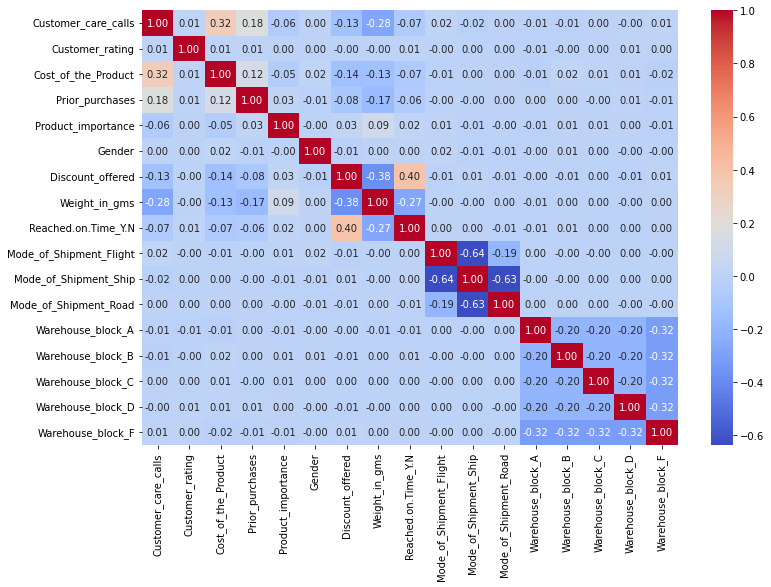

In [21]:
# check the variables are independent
ecommerce = get_ecommerce(data_path=Path('./data'))
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.heatmap(ecommerce.iloc[:, 1:].corr(), cmap='coolwarm', annot=True, fmt=".2f", ax=ax)
plt.show()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

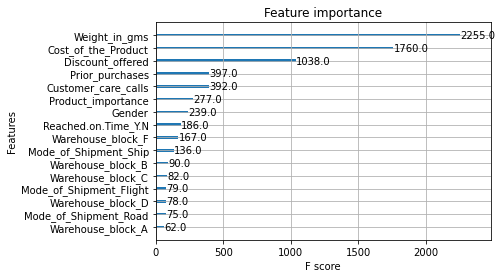

In [22]:
xgb.plot_importance(best_bst)

In [128]:
rt_pred = best_bst.predict(dtest)
explainer = shap.TreeExplainer(best_bst)
shap_values = explainer.shap_values(dtest)

In [ ]:
idx = dtest.
shap.force_plot(explainer.expected_value, shap_values[0][0, :], X_display.iloc[0,:])


In [135]:
dtest.size()

AttributeError: 'DMatrix' object has no attribute 'size'

In [131]:
shap_values[0].shape

(2200, 16)

**Problem 2: Reached on time or not**

In [94]:
ecommerce = get_ecommerce(data_path=Path('./data'))
ontime_data = ecommerce.copy()
ontime_data = ontime_data.sample(frac=1)
ontime_data_y = ontime_data.iloc[:,9]
ontime_data_X = ontime_data.drop(['Customer_rating', 'Reached.on.Time_Y.N', 'ID'], axis=1)

In [ ]:
ot_corr = ontime_data.drop(['ID', 'Customer_rating'], axis=1).corr()
ot_corr.iloc[7:8,:]

In [ ]:
ot_X_train, ot_y_train, ot_X_test, ot_y_test = separate_dataset(ontime_data_X, ontime_data_y)

**Implement your classification model here**

In [ ]:
ot_acc = accuracy_score(ot_y_test, ot_pred)
print(ot_acc)

**Initialize classification explainer here**

**1.2 Marketing Champaign in bank**

Abstract:
The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe a term deposit (variable y).

Data Set Information:
The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

Attribute Information:

Bank client data:
- Age (numeric)
- Job : type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', - 'technician', 'unemployed', 'unknown')
- Marital : marital status (categorical: 'divorced', 'married', 'single', 'unknown' ; note: 'divorced' means divorced or widowed)
- Education (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')
- Default: has credit in default? (categorical: 'no', 'yes', 'unknown')
- Housing: has housing loan? (categorical: 'no', 'yes', 'unknown')
- Loan: has personal loan? (categorical: 'no', 'yes', 'unknown')

Related with the last contact of the current campaign:
- Contact: contact communication type (categorical: 'cellular','telephone')
- Month: last contact month of year (categorical: 'jan', 'feb', 'mar', …, 'nov', 'dec')
- Dayofweek: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
- Duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

Other attributes:
- Campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact) 
- Pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
- Previous: number of contacts performed before this campaign and for this client (numeric)
- Poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Social and economic context attributes
- Emp.var.rate: employment variation rate - quarterly indicator (numeric)
- Cons.price.idx: consumer price index - monthly indicator (numeric)
- Cons.conf.idx: consumer confidence index - monthly indicator (numeric)
- Euribor3m: euribor 3 month rate - daily indicator (numeric)
- Nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
- y - has the client subscribed a term deposit? (binary: 'yes', 'no')

Analysis Steps:
Atribute information Analysis.
Machine Learning (Logistic Regression, KNN, SVM, Decision Tree,
Random Forest, Naive Bayes)
Deep Learning (ANN)

Source:
Dataset from : http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

In [ ]:
marketing = pd.read_csv("./data/banking_marketing/bank_data.csv", sep=";")

In [ ]:
marketing['default'] = marketing['default'].replace("unknown", "no")
marketing['housing'] = marketing['housing'].replace("unknown", "no")
marketing['loan'] = marketing['loan'].replace("unknown", "no")

In [ ]:
cats = {}
for c in marketing.columns:
    if marketing[c].dtype == 'object':
        cats[c] = np.sort(marketing[c].unique())

In [ ]:
marketing_onhot = to_onehot(marketing, ['y'])

In [ ]:
marketing_onhot

In [ ]:
marketing_onhot['y'] = marketing_onhot['y'].replace(to_replace=['no', 'yes'], value=[0, 1])

In [ ]:
corr = marketing_onhot.corr()

In [ ]:
corr.iloc[10:11,:]

In [ ]:
marketing_onhot = marketing_onhot.sample(frac=1)
mkt_y = marketing_onhot['y']
mkt_X = marketing_onhot.drop('y', axis=1)

In [ ]:
mkt_X_train, mkt_y_train, mkt_X_test, mkt_y_test = separate_dataset(mkt_X, mkt_y)

**Implement classification model here**

In [ ]:
mkt_pred = mkt_classifier.predict(mkt_X_test)
mkt_acc = accuracy_score(mkt_y_test, mkt_pred)
print(mkt_acc)

**Explainer implementation here**

**1.3 Beijing Housing**

Housing price of Beijing from 2011 to 2017, fetching from Lianjia.com

Content
It includes URL, ID, Lng, Lat, CommunityID, TradeTime, DOM(days on market), Followers, Total price, Price, Square, Living Room, number of Drawing room, Kitchen and Bathroom, Building Type, Construction time. renovation condition, building structure, Ladder ratio( which is the proportion between number of residents on the same floor and number of elevator of ladder. It describes how many ladders a resident have on average), elevator, Property rights for five years（It's related to China restricted purchase of houses policy), Subway, District, Community average price.

- url: the url which fetches the data
- id: the id of transaction
- Lng: and Lat coordinates, using the BD09 protocol.
- Cid: community id
- tradeTime: the time of transaction
- DOM: active days on market.Know more in https://en.wikipedia.org/wiki/Days_on_market
- followers: the number of people follow the transaction.
- totalPrice: the total price
- price: the average price by square
- square: the square of house
- livingRoom: the number of living room
- drawingRoom: the number of drawing room
- kitchen: the number of kitchen
- bathroom the number of bathroom
- floor: the height of the house. I will turn the Chinese characters to English in the next version.
- buildingType: including tower( 1 ) , bungalow( 2 )，combination of plate and tower( 3 ), plate( 4 ).
- constructionTime: the time of construction
- renovationCondition: including other( 1 ), rough( 2 ),Simplicity( 3 ), hardcover( 4 )
- buildingStructure: including unknow( 1 ), mixed( 2 ), brick and wood( 3 ), brick and concrete( 4 ),steel( 5 ) and steel-concrete composite ( 6 ).
- ladderRatio: the proportion between number of residents on the same floor and number of elevator of ladder. It describes how many ladders a resident have on - average.
- elevator: have ( 1 ) or not have elevator( 0 )
- fiveYearsProperty: if the owner have the property for less than 5 years,

Target column: **totalPrice** (plz remove **price** column from the predictors)

Most data is traded in 2011-2017, some of them is traded in Jan,2018, and some is even earlier(2010,2009)

All the data was fetching from https://bj.lianjia.com/chengjiao.

Acknowledgements
All the data was fetching from Lianjia

Inspiration
It may help you predict the housing price of Beijing.

In [ ]:
from datetime import datetime

In [ ]:
housing = pd.read_csv("./data/housing/beijing_housing_2.csv")

In [ ]:
housing.drop("url", inplace=True, axis=1)

In [ ]:
housing['constructionTime'] = housing['constructionTime'].replace("未知", 'nan')
housing.drop(housing[(housing['constructionTime'] == '1')
                     | (housing['constructionTime'] == '0')
                     | (housing['constructionTime'] == 'nan')].index, inplace=True)
housing['constructionTime'] = housing['constructionTime'].astype('int')

In [ ]:
housing['floor_num'] = housing['floor'].apply(lambda x : x.split(" ")[-1])
housing['floor_type'] = housing['floor'].apply(lambda x : x.split(" ")[0])
housing['floor_num'] = housing['floor_num'].astype('int')
housing.drop('floor', inplace=True, axis=1)
housing.drop(housing[housing['floor_type'] == '未知'].index, inplace=True)

In [ ]:
housing['floor_type'] = housing['floor_type'].replace(to_replace=['顶','高','中','低','底'], value=[5,4,3,2,1])
housing['floor_type'] = housing['floor_type'].astype('int')

In [ ]:
housing['tradeTime'] = housing['tradeTime'].apply(lambda x: int(datetime.timestamp(datetime.strptime(x, "%Y-%m-%d"))))
housing['tradeTime'] = housing['tradeTime'].astype('int')

In [ ]:
housing['livingRoom'] = housing['livingRoom'].astype('int')
housing['drawingRoom'] = housing['drawingRoom'].astype('int')
housing['bathRoom'] = housing['bathRoom'].astype('int')

**Filling missing value of DOM & buildingType**

As you can see, DOM hightly correlates with totalPrice, while buildingType weakly correlates with totalPrice. 

In [ ]:
dom_mean = housing['DOM'].mean()

In [ ]:
dataset = housing.sample(frac=1)
y = dataset.iloc[:,7]
X = dataset.copy()

In [ ]:
X.drop(["id", "Cid", "price", "ladderRatio", "fiveYearsProperty", "totalPrice"], inplace=True, axis=1)

In [ ]:
X['DOM'].fillna(value=dom_mean, inplace=True)

In [ ]:
X_train, y_train, X_test, y_test = separate_dataset(X, y)

**Initialize model & explainer**

In [ ]:
housing_pred = housing_model.predict(X_test)

In [ ]:
housing_mae = mae(y_test, housing_pred)
print(housing_mae)

**Explainer implementation**